In [ ]:
#pip install tensorflow==2.10

In [ ]:
!pip3 install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 4.4 MB/s 
     |████████████████████████████████| 588.3 MB 6.5 kB/s 
     |████████████████████████████████| 439 kB 53.3 MB/s 
     |████████████████████████████████| 1.7 MB 40.1 MB/s 
     |████████████████████████████████| 6.0 MB 34.5 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.

In [ ]:
import tensorflow_hub as thub
import tensorflow_text

In [ ]:
import base64
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

import pandas as pd
import warnings
warnings.filterwarnings("ignore")
tf.get_logger().setLevel('ERROR')



# Get data

### imgs

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
PATH = '/content/drive/MyDrive/lab_2/IMDB_new/final_storage/train'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)
seed = 42


In [ ]:
train_dir

'/content/drive/MyDrive/lab_2/IMDB_new/final_storage/train/train'

In [ ]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory('/content/drive/MyDrive/lab_2/IMDB_new/final_storage/train',
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            validation_split = 0.2,
                                                            subset = 'training',
                                                            seed = 42)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory('/content/drive/MyDrive/lab_2/IMDB_new/final_storage/train',
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE,
                                                                 validation_split = 0.2,
                                                                 subset = 'validation',
                                                                 seed = 42)



Found 8297 files belonging to 24 classes.
Using 6638 files for training.
Found 8297 files belonging to 24 classes.
Using 1659 files for validation.


In [ ]:
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    '/content/drive/MyDrive/lab_2/IMDB_new/old_storage_text/train',
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset='training',
    seed=seed)

# class_names = raw_train_ds.class_names
# train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    '/content/drive/MyDrive/lab_2/IMDB_new/old_storage_text/train',
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset='validation',
    seed=seed)


Found 8297 files belonging to 24 classes.
Using 6638 files for training.
Found 8297 files belonging to 24 classes.
Using 1659 files for validation.


#### check sets that coincide 

In [ ]:
img_labels = []
for i in train_dataset:
  img_labels.append(i[1].numpy())



txt_labels = []
for i in raw_train_ds:
  txt_labels.append(i[1].numpy())

#(np.array(txt_labels) == np.array(img_labels)).all()


# Model setup

['action', 'adventure', 'animation', 'biography', 'comedy', 'crime', 'documentary', 'drama', 'family', 'fantasy', 'film-noir', 'history', 'horror', 'music', 'musical', 'mystery', 'romance', 'sci-fi', 'short', 'sport', 'superhero', 'thriller', 'war', 'western']


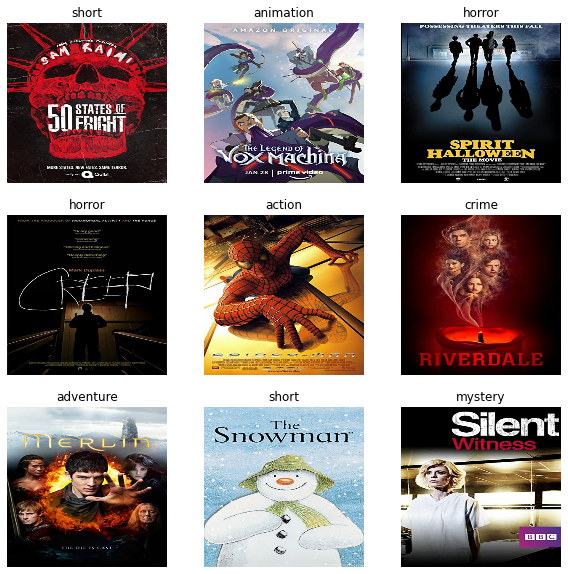

In [ ]:

class_names = train_dataset.class_names
classes_num  = len(class_names)
print(class_names)

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

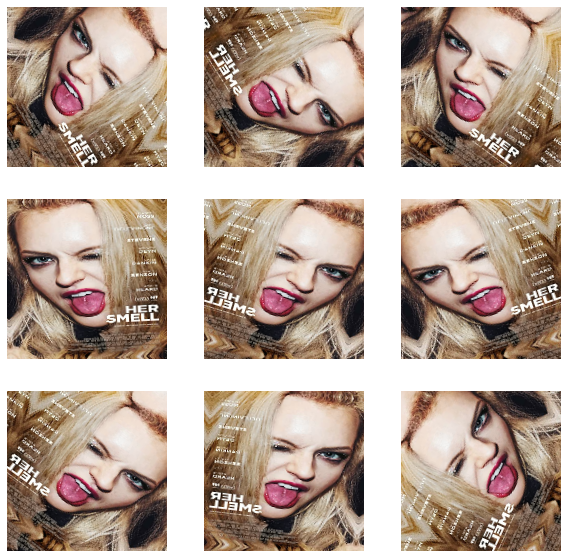

In [ ]:

data_augmentation = tf.keras.Sequential([
   tf.keras.layers.RandomFlip('horizontal'),
   tf.keras.layers.RandomRotation(0.2),
])


for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
#IMG_SHAPE = IMG_SIZE 
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(label_batch.shape)

(32,)


In [ ]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [ ]:
bert_preprocess_model = thub.KerasLayer(tfhub_handle_preprocess)
bert_model = thub.KerasLayer(tfhub_handle_encoder)

In [ ]:
classes_num

24

In [ ]:
import re, string


def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)

    points = tf.strings.regex_replace(lowercase, '[%s]' % re.escape(string.punctuation), ' ')
    extra_space = tf.strings.regex_replace(points, ' +', ' ')
    
    return extra_space


category_layer = tf.keras.layers.CategoryEncoding(
  num_tokens=classes_num,
  #output_mode='binary'
  output_mode="one_hot"
   #output_mode="multi_hot"

)

def vectorize_text(text, label):
  # print('vectorize_text input:', int(label))

  # text = tf.expand_dims(text, -1)
  text = tf.expand_dims(text, axis=-1)
  
  # label_vector = tf.keras.utils.to_categorical(label, num_classes=labels_size)
  label_vector = category_layer(label)

  # for i in label:
  #   label_vector[int(i)] = 1

  # print('vectorize_text output:', label_vector)
  # return vectorize_layer(text), label_vector
  return text, label_vector

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
class_names = raw_train_ds.class_names


train_ds = raw_train_ds.map(vectorize_text)
# train_ds = raw_train_ds
train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = raw_val_ds.map(vectorize_text)
# val_ds = raw_val_ds
val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# test_ds = raw_test_ds.map(vectorize_text)
# # .cache().prefetch(buffer_size=AUTOTUNE)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 1), dtype=tf.string, name=None), TensorSpec(shape=(None, 24), dtype=tf.float32, name=None))>

## Model itself

In [ ]:
from tensorflow.keras.layers import Dense, concatenate
import tensorflow.keras.losses as losses



In [ ]:
base_model.trainable = True
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
prediction_layer = tf.keras.layers.Dense(classes_num)
prediction_batch = prediction_layer(feature_batch_average)


In [ ]:
try: 
    del model
except:
    2+2

inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs_img = tf.keras.layers.Dense(100)(x)
#outputs_img = prediction_layer(x)

In [ ]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
# text_input = tf.keras.layers.Input(shape=(),)

# text_input = layers.Embedding(input_dim=max_features+1, output_dim=embedding_dim, input_length=sequence_length, name='vectorized_text')

preprocessing_layer = thub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
encoder_inputs = preprocessing_layer(text_input)

encoder = thub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
outputs = encoder(encoder_inputs)

net = outputs['pooled_output']
net = tf.keras.layers.Dropout(0.4)(net)
net = tf.keras.layers.Dense(24, name='classifier')(net)
#net = tf.keras.layers.Dropout(0.5)(net)
model_merging = concatenate([outputs_img,net]) 

final = tf.keras.layers.Dense(classes_num, activation='sigmoid', name='finalmente')(model_merging)


model = tf.keras.Model([inputs,text_input], final)

In [ ]:
'''
try: 
    del model
except:
    2+2

inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs_img = tf.keras.layers.Dense(100)(x)
#outputs_img = prediction_layer(x)

text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
# text_input = tf.keras.layers.Input(shape=(),)
# text_input = layers.Embedding(input_dim=max_features+1, output_dim=embedding_dim, input_length=sequence_length, name='vectorized_text')

preprocessing_layer = thub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
encoder_inputs = preprocessing_layer(text_input)
encoder = thub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
outputs = encoder(encoder_inputs)
# net = outputs['pooled_output']
net = outputs['sequence_output']
net = tf.keras.layers.Dropout(0.2)(net)
# net = tf.keras.layers.Conv1D(filters=128, kernel_size=5, activation='relu')(net)  # 327808
net = tf.keras.layers.Conv1D(filters=256, kernel_size=5, activation='relu')(net)  # 31744
# net = tf.keras.layers.Flatten()(net)
# net = tf.keras.layers.Conv1D(filters=labels_size, kernel_size=5, activation='relu')(net)  #c
net = tf.keras.layers.Conv1D(filters=classes_num, kernel_size=5, activation='sigmoid')(net)  # 
#net = tf.keras.layers.Dense(labels_size, activation='sigmoid', name='classifier')(net)
net = tf.keras.layers.Flatten()(net)
net = tf.keras.layers.Dense(100)(net)

model_merging = concatenate([outputs_img,net]) 

final = tf.keras.layers.Dense(classes_num, activation='sigmoid', name='finalmente')(model_merging)


model = tf.keras.Model([inputs,text_input], final)
'''

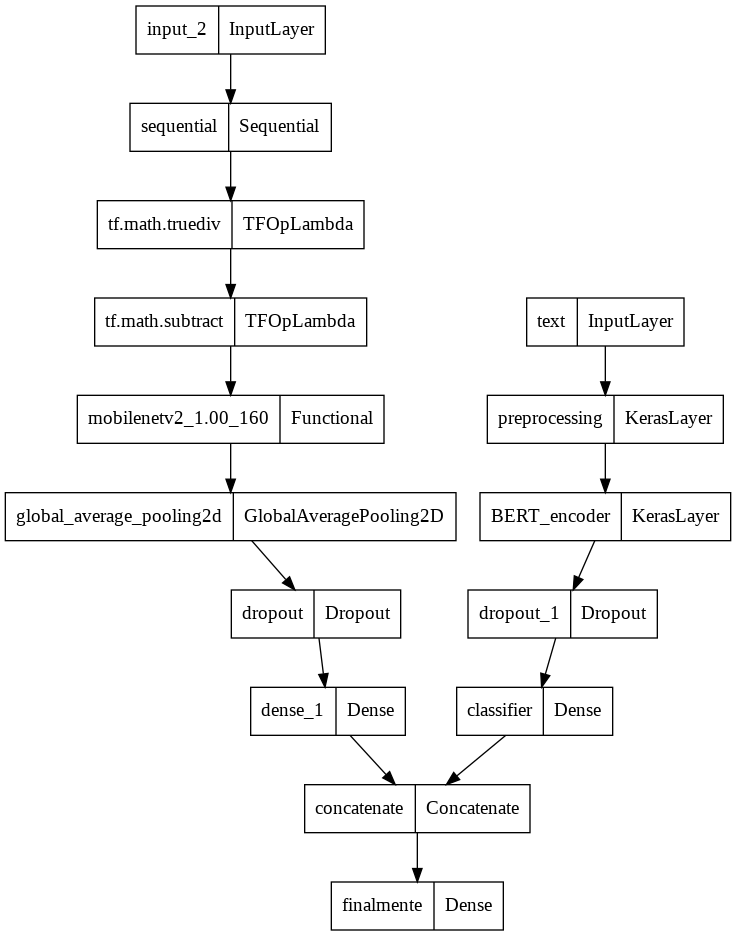

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
import tensorflow.keras.losses as losses
base_learning_rate = 0.0001

# model.compile(
model.compile(
    # loss=losses.BinaryCrossentropy(from_logits=True),
    loss=losses.CategoricalCrossentropy(),
    #optimizer='adam',
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10), 
    # metrics=tf.metrics.BinaryAccuracy(threshold=0.0)
    #metrics=tf.metrics.CategoricalAccuracy()
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 160, 160, 3)  0           ['input_2[0][0]']                
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 160, 160, 3)  0           ['sequential[0][0]']             
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 160, 160, 3)  0           ['tf.math.truediv[0][0]']    

### Prepare data for multi-inputs

In [ ]:

img_features = []
for img_batch, img_label_batch in train_dataset:
    for singe in img_batch:
        img_features.append(singe)
text_features = []
text_labels = []
for text_batch, label_batch in train_ds:
    for single in text_batch:
        text_features.append(single)
    for single in label_batch:
        text_labels.append(single)

In [ ]:
text_features_st = tf.stack(text_features)
img_features_st = tf.stack(img_features)
labels_st = tf.stack(text_labels)

In [ ]:
a = tf.data.Dataset.from_tensor_slices(img_features_st)
b = tf.data.Dataset.from_tensor_slices(text_features_st)
c = tf.data.Dataset.from_tensor_slices(labels_st)

In [ ]:
a = a.batch(32)
b = b.batch(32)
c = c.batch(32)

In [ ]:
combined_dataset = tf.data.Dataset.zip(((a,b),c))

In [ ]:
'''
initial_epochs = 15

history = model.fit(combined_dataset , epochs=initial_epochs)
'''

Epoch 1/15
208/208 [==============================] - 126s 407ms/step - loss: 3.3443 - accuracy: 0.0575
Epoch 2/15
208/208 [==============================] - 74s 354ms/step - loss: 3.0268 - accuracy: 0.1193
Epoch 3/15
208/208 [==============================] - 73s 353ms/step - loss: 2.7920 - accuracy: 0.1990
Epoch 4/15
208/208 [==============================] - 75s 361ms/step - loss: 2.6354 - accuracy: 0.2474
Epoch 5/15
208/208 [==============================] - 74s 353ms/step - loss: 2.5246 - accuracy: 0.2694
Epoch 6/15
208/208 [==============================] - 73s 352ms/step - loss: 2.4124 - accuracy: 0.3048
Epoch 7/15
208/208 [==============================] - 75s 359ms/step - loss: 2.3280 - accuracy: 0.3257
Epoch 8/15
208/208 [==============================] - 73s 352ms/step - loss: 2.2557 - accuracy: 0.3405
Epoch 9/15
208/208 [==============================] - 75s 359ms/step - loss: 2.1823 - accuracy: 0.3590
Epoch 10/15
208/208 [==============================] - 75s 362ms/step - 

In [ ]:
img_features = []
for img_batch, img_label_batch in validation_dataset:
    for singe in img_batch:
        img_features.append(singe)
text_features = []
text_labels = []
for text_batch, label_batch in val_ds:
    for single in text_batch:
        text_features.append(single)
    for single in label_batch:
        text_labels.append(single)

In [ ]:
val_text_features_st = tf.stack(text_features)
val_img_features_st = tf.stack(img_features)
val_labels_st = tf.stack(text_labels)

In [ ]:
val_a = tf.data.Dataset.from_tensor_slices(val_img_features_st)
val_b = tf.data.Dataset.from_tensor_slices(val_text_features_st)
val_c = tf.data.Dataset.from_tensor_slices(val_labels_st)

In [ ]:
val_a = val_a.batch(32)
val_b = val_b.batch(32)
val_c = val_c.batch(32)

In [ ]:
validation_combined_dataset = tf.data.Dataset.zip(((val_a,val_b),val_c))

### Try with validation

In [ ]:
initial_epochs = 15
history = model.fit(combined_dataset , epochs=initial_epochs, validation_data=validation_combined_dataset)

Epoch 1/15
208/208 [==============================] - 135s 462ms/step - loss: 3.2103 - accuracy: 0.0773 - val_loss: 2.9868 - val_accuracy: 0.1356
Epoch 2/15
208/208 [==============================] - 80s 384ms/step - loss: 2.9061 - accuracy: 0.1552 - val_loss: 2.7889 - val_accuracy: 0.2128
Epoch 3/15
208/208 [==============================] - 81s 391ms/step - loss: 2.7513 - accuracy: 0.2073 - val_loss: 2.6480 - val_accuracy: 0.2495
Epoch 4/15
208/208 [==============================] - 80s 383ms/step - loss: 2.6448 - accuracy: 0.2362 - val_loss: 2.5602 - val_accuracy: 0.2664
Epoch 5/15
208/208 [==============================] - 80s 383ms/step - loss: 2.5692 - accuracy: 0.2579 - val_loss: 2.4921 - val_accuracy: 0.2881
Epoch 6/15
208/208 [==============================] - 81s 390ms/step - loss: 2.5139 - accuracy: 0.2766 - val_loss: 2.4605 - val_accuracy: 0.2881
Epoch 7/15
208/208 [==============================] - 79s 382ms/step - loss: 2.4353 - accuracy: 0.2906 - val_loss: 2.4326 - val_a

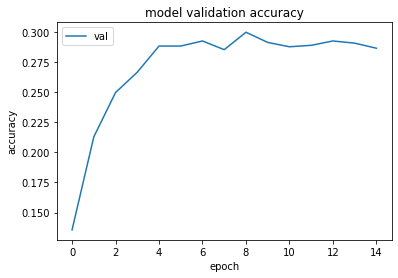

In [ ]:
plt.plot(history.history['val_accuracy'])
plt.title('model validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['val'], loc='upper left')
plt.show()

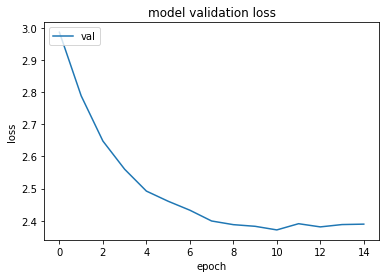

In [ ]:
plt.plot(history.history['val_loss'])
plt.title('model validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['val'], loc='upper left')
plt.show()

###also plots

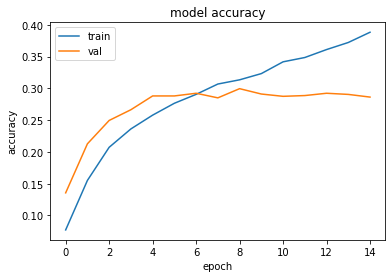

In [ ]:
import keras
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

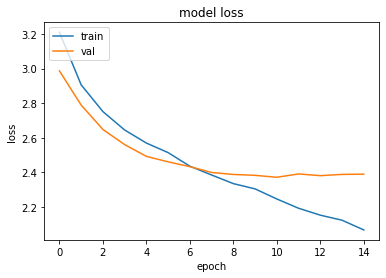

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### save the model

In [ ]:
# loading library
import pickle

In [ ]:
# create an iterator object with write permission - model.pickle
with open('/content/drive/MyDrive/lab_2/IMDB_new/model_pkl', 'wb') as files:
    pickle.dump(model, files)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......concatenate
.........vars
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......functional
.........layers
............add
...............vars
............add_1
...............vars
............add_2
...............vars
............add_3
...............vars
............add_4
...............vars
............add_5
...............vars
............add_6
...............vars
............add_7
...............vars
............add_8
...............vars
............add_9
...............vars
............batch_normalization
...............vars
..................0
..................1
..................2
..................3
............batch_normalization_1
...............vars
..................0
..................1
..................2
...........

In [ ]:
# load saved model
with open('/content/drive/MyDrive/lab_2/IMDB_new/model_pkl' , 'rb') as f:
    lr = pickle.load(f)